# Study 3 – Dataset characterisation and signal quality analysis

This notebook implements Study 3 of the thesis, focusing on:
- Global characterisation of the ePatch ECG dataset
- Seizure distribution and inter-seizure intervals
- Segment-level labelling (seizure vs. baseline) using fixed 60 s windows
- Signal quality and noise characteristics using SQI and spectral metrics
- Peri-ictal windows around seizures (legacy window scheme)
- Illustrative case studies and visualisations


## Imports

In [19]:
from pathlib import Path
from dataclasses import asdict
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Project style
from src.hrv_epatch.plots.plotstyle import set_project_style
set_project_style()  # ensartet grøn stil på alle plots

# Dataset-API
from src.hrv_epatch.dataset.index import build_recording_index
from src.hrv_epatch.dataset.loader import iter_recordings
from src.hrv_epatch.dataset.seizures import build_seizure_events_from_df, SeizureEvent
from src.hrv_epatch.dataset.summary import (
    compute_dataset_overview,
    build_patient_summary,
    compute_within_recording_isi,
    summarise_isi,
)
from src.hrv_epatch.dataset.segments import build_segment_index

# IO / TDMS
from src.hrv_epatch.io.tdms import load_tdms_from_path, TdmsMeta

# SQI og noise metrics
from src.hrv_epatch.sqi.sqi_bukhari import (
    SQIConfig,
    SQIThresholds,
    compute_sqi_for_many_segments,
    classify_many_segments,
)
from src.hrv_epatch.preprocessing.denoise_metrics import noise_metrics

# Frequenzy / PSD
from src.hrv_epatch.features.frequency import (
    compute_psd,
    summarize_psd_bands,
    plot_psd,
)

# Seizure-windows (peri-ictal)
from src.hrv_epatch.seizure.windows import analyze_shifted_windows

# Plots
from src.hrv_epatch.plots.seizure_gantt import plot_gantt_from_index
from src.hrv_epatch.plots.rpeak import plot_raw_vs_clean_with_peaks

# Eventually: Jeppesen/HRV-pipeline if needed
# from src.hrv_epatch.rpeak.jeppesen_pipeline import run_pipeline_from_ecg

from src.hrv_epatch.dataset.dataset_builders import build_df_rec_and_df_evt
from src.hrv_epatch.dataset.peri_windows import build_peri_windows_for_recording

from src.hrv_epatch.preprocessing.denoise_metrics import noise_metrics

from src.hrv_epatch.features.frequency import compute_psd, summarize_psd_bands

plt.close("all")
pd.options.display.max_columns = 50


## Configuration

In [2]:
# >>> Tilpas disse til din lokale struktur <<<
BASE_DIR = Path(r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne")
TDMS_ROOT = BASE_DIR / "Patients ePatch data"
ANN_ROOT = BASE_DIR / "Seizure log ePatch patients with seizures - excluded seizures removed"

OUT_DIR = Path(r"E:\Speciale - Results") / "_analysis" / "study3"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Segment- og vinduesparametre
SEGMENT_LEN_S = 60.0  # faste 60 s segmenter til global karakterisering
PERIICTAL_OFFSETS_MIN = [-20, -2, 0, 2, 20]  # eksempel-værdier, kan tweakes
PERIICTAL_WINDOW_LEN_S = 60.0  # længde af hver peri-ictal vindue
FS_FALLBACK = 512.0


## 1. Build recording index

We first construct a structured index of all TDMS recordings and their corresponding
annotation files using the `hrv_epatch.dataset.index` module.

In [3]:
recording_index = build_recording_index(TDMS_ROOT, ANN_ROOT)
recording_index[:5]

[RecordingEntry(key=RecordingKey(patient_id=1, enrollment_id=None, recording_id=1), tdms_path=WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Patients ePatch data/Patient 1/recording 1/Patient 1_1.tdms'), annotation_path=WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Seizure log ePatch patients with seizures - excluded seizures removed/patient 1.xls')),
 RecordingEntry(key=RecordingKey(patient_id=1, enrollment_id=None, recording_id=2), tdms_path=WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Patients ePatch data/Patient 1/recording 2/Patient 1_2.tdms'), annotation_path=WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Seizure log ePatch patients with seizures - excluded seizures removed/patient 1.xls')),
 RecordingEntry(key=RecordingKey(patient_id=2, enrollment_id=None, recording_id=1), tdms_path=WindowsPath(

In [4]:
entries = build_recording_index(TDMS_ROOT, ANN_ROOT)

print("Antal entries:", len(entries))
for e in entries[:10]:
    print(
        "UID:",
        f"P{e.key.patient_id:02d}{e.key.enrollment_id or ''}_R{e.key.recording_id:02d}",
        "| TDMS:", e.tdms_path.name,
        "| ANN:", e.annotation_path.name if e.annotation_path is not None else None,
    )


Antal entries: 72
UID: P01_R01 | TDMS: Patient 1_1.tdms | ANN: patient 1.xls
UID: P01_R02 | TDMS: Patient 1_2.tdms | ANN: patient 1.xls
UID: P02_R01 | TDMS: Patient 2_1.tdms | ANN: patient 2.xls
UID: P03_R01 | TDMS: Patient 3_1.tdms | ANN: patient 3.xls
UID: P03_R02 | TDMS: Patient 3_2.tdms | ANN: patient 3.xls
UID: P04_R01 | TDMS: Patient 4_1.tdms | ANN: patient 4.xls
UID: P05_R01 | TDMS: Patient 5_1.tdms | ANN: patient 5.xls
UID: P06_R01 | TDMS: Patient 6_1.tdms | ANN: patient 6.xls
UID: P06_R02 | TDMS: Patient 6_2.tdms | ANN: patient 6.xls
UID: P07_R01 | TDMS: Patient 7_1.tdms | ANN: patient 7.xls


## 1.1 Build recording- and event-level tables

We iterate over all recordings and build:
- `df_rec`: one row per recording (duration, patient/enrollment, etc.)
- `df_evt`: one row per seizure event (absolute start/stop, recording ID, etc.)

In [5]:
df_rec, df_evt = build_df_rec_and_df_evt(TDMS_ROOT, ANN_ROOT, test_mode=True)
print(len(df_rec), "recordings")
print(len(df_evt), "seizure events")
df_evt.head()


[INFO] P01_R01: 1 seizures
[INFO] P01_R02: 2 seizures
[INFO] P02_R01: 9 seizures
[INFO] P03_R01: 2 seizures
[INFO] P03_R02: 1 seizures
[INFO] Test mode active - stopping after 5 recordings.
5 recordings
15 seizure events


,recording_uid,patient_id,enrollment_id,recording_id,seizure_id,t0_s,t1_s,absolute_start,absolute_end
0,P01_R01,1,None,1,1,130187.0,130228.0,2016-02-23 23:14:01,2016-02-23 23:14:42
1,P01_R02,1,None,2,2,47163.0,47185.0,2016-02-25 05:21:03,2016-02-25 05:21:25
2,P01_R02,1,None,2,3,134180.0,134210.0,2016-02-26 05:31:20,2016-02-26 05:31:50
3,P02_R01,2,None,1,1,3209.0,3244.0,2016-05-03 14:12:34,2016-05-03 14:13:09
4,P02_R01,2,None,1,2,5841.0,5878.0,2016-05-03 14:56:26,2016-05-03 14:57:03


In [6]:
df_rec[["recording_uid", "patient_id", "recording_start", "recording_end", "rec_duration_s"]].head()


,recording_uid,patient_id,recording_start,recording_end,rec_duration_s
0,P01_R01,1,2016-02-22 11:04:14,2016-02-24 16:09:49.750000,191135.750000
1,P01_R02,1,2016-02-24 16:15:00,2016-02-26 09:00:00.001953,146700.001953
2,P02_R01,2,2016-05-03 13:19:05,2016-05-04 07:03:49.750000,63884.750000
3,P03_R01,3,2016-09-05 11:19:32,2016-09-07 10:49:54.500000,171022.500000
4,P03_R02,3,2016-09-07 10:50:46,2016-09-09 09:44:08.000000,168802.000000


## 1.2 Segment index with fixed windows

We now discretise each recording into non-overlapping 60 s segments and
label each segment as `seizure` or `baseline` depending on overlap with any seizure.
This forms the basis for segment-level statistics and SQI.


In [7]:
segment_index = build_segment_index(df_rec, df_evt, window_s=SEGMENT_LEN_S)
segment_index.head()


,segment_id,patient_id,enrollment_id,recording_uid,segment_start,segment_end,label
0,0,1,None,P01_R01,2016-02-22 11:04:14,2016-02-22 11:05:14,baseline
1,1,1,None,P01_R01,2016-02-22 11:05:14,2016-02-22 11:06:14,baseline
2,2,1,None,P01_R01,2016-02-22 11:06:14,2016-02-22 11:07:14,baseline
3,3,1,None,P01_R01,2016-02-22 11:07:14,2016-02-22 11:08:14,baseline
4,4,1,None,P01_R01,2016-02-22 11:08:14,2016-02-22 11:09:14,baseline


In [8]:
all_windows = []

for ridx, rec in df_rec.iterrows():
    rec_uid = rec["recording_uid"]
    tdms_path = rec["tdms_path"]

    sig, meta = load_tdms_from_path(tdms_path, channel_hint="EKG")

    df_evt_rec = df_evt[df_evt["recording_uid"] == rec_uid]

    if df_evt_rec.empty:
        continue

    win_list = build_peri_windows_for_recording(
        sig=sig,
        meta=meta,
        df_evt_rec=df_evt_rec,
        rec_uid=rec_uid,
    )

    all_windows.extend(win_list)

len(all_windows)

75

In [9]:
peri_rows = []

for w in all_windows:
    peri_rows.append({
        "recording_uid": w.recording_uid,
        "patient_id": w.patient_id,
        "seizure_id": w.seizure_id,
        "role": w.role,
        "t_start": w.t_start,
        "t_end": w.t_end,
        "duration_s": w.t_end - w.t_start,
        "fs": w.fs,
        "n_samples": len(w.x),
        "signal": w.x,  # raw ECG segment
    })

df_peri = pd.DataFrame(peri_rows)
df_peri.head()


,recording_uid,patient_id,seizure_id,role,t_start,t_end,duration_s,fs,n_samples,signal
0,P01_R01,1,1,baseline_far,128987.0,129047.0,60.0,512.0,30720,"[996.1921721217676, 825.3376363775088, 646.215..."
1,P01_R01,1,1,baseline_near,130067.0,130127.0,60.0,512.0,30720,"[-6.889295796138802, -4.133577477683015, -4.13..."
2,P01_R01,1,1,ictal,130187.0,130228.0,41.0,512.0,20992,"[-144.67521171892815, -155.6980849927513, -158..."
3,P01_R01,1,1,post_near,130307.0,130367.0,60.0,512.0,30720,"[-141.91949340047236, -141.91949340047236, -14..."
4,P01_R01,1,1,post_far,131387.0,131447.0,60.0,512.0,30720,"[-12.400732433050376, -9.645014114594588, -9.6..."


## 2 Extract Features for Each Peri-Ictal window
Noise Features based on denoise_metrics.py

In [17]:
# Beregn noise features for hvert vindue
noise_feature_rows = []

for idx, row in df_peri.iterrows():
    x = row["signal"]
    fs = row["fs"]

    nm = noise_metrics(x, fs)

    noise_feature_rows.append({
        "recording_uid": row["recording_uid"],
        "patient_id": row["patient_id"],
        "seizure_id": row["seizure_id"],
        "role": row["role"],

        # Basics
        "rms": nm["rms"],
        "line_noise_ratio": nm["line_noise_ratio"],
        "hf_noise_ratio": nm["hf_noise_ratio"],
        "snr_qrs": nm["snr_qrs"],

        # Sub-bands (we extract from nm["bands"])
        "ulf_rel":   nm["bands"].loc[nm["bands"].band=="ULF", "rel_power"].values[0],
        "qrs_rel":   nm["bands"].loc[nm["bands"].band=="QRS", "rel_power"].values[0],
        "hf_rel":    nm["bands"].loc[nm["bands"].band=="HF",  "rel_power"].values[0],
        "line_rel":  nm["bands"].loc[nm["bands"].band=="Line","rel_power"].values[0],
    })

df_noise = pd.DataFrame(noise_feature_rows)
df_noise.head()


,recording_uid,patient_id,seizure_id,role,rms,line_noise_ratio,hf_noise_ratio,snr_qrs,ulf_rel,qrs_rel,hf_rel,line_rel
0,P01_R01,1,1,baseline_far,251.116655,0.002971,0.015490,0.690854,0.345709,0.408583,0.006329,0.001214
1,P01_R01,1,1,baseline_near,195.479175,0.002802,0.015186,1.735587,0.065901,0.634448,0.009635,0.001778
2,P01_R01,1,1,ictal,1759.017586,0.004375,0.026703,0.048828,0.845632,0.046555,0.001243,0.000204
3,P01_R01,1,1,post_near,600.681599,0.008856,0.062229,0.147161,0.760636,0.128283,0.007983,0.001136
4,P01_R01,1,1,post_far,324.644501,0.002032,0.013038,2.295593,0.013677,0.696564,0.009082,0.001415


PSD Features

In [ ]:
psd_rows = []

for idx, row in df_peri.iterrows():
    x = row["signal"]
    fs = row["fs"]

    f, Pxx = compute_psd(x, fs)
    bands = summarize_psd_bands(f, Pxx)

    # Convert bands DF -> dictionary
    band_dict = {f"{b.band}_power": b.power for _, b in bands.iterrows()}
    band_dict.update({f"{b.band}_rel": b.rel_power for _, b in bands.iterrows()})

    psd_rows.append({
        "recording_uid": row["recording_uid"],
        "patient_id": row["patient_id"],
        "seizure_id": row["seizure_id"],
        "role": row["role"],
        **band_dict
    })

df_psd = pd.DataFrame(psd_rows)
df_psd.head()


,recording_uid,patient_id,seizure_id,role,ULF_power,LF_power,QRS-ish_power,HF(40-100)_power,Line(48-52)_power,ULF_rel,LF_rel,QRS-ish_rel,HF(40-100)_rel,Line(48-52)_rel
0,P01_R01,1,1,baseline_far,1.472116e+04,10182.384759,17398.482038,269.500945,51.686736,0.345709,0.239121,0.408583,0.006329,0.001214
1,P01_R01,1,1,baseline_near,2.130206e+03,9359.869345,20508.178370,311.435957,57.472108,0.065901,0.289560,0.634448,0.009635,0.001778
2,P01_R01,1,1,ictal,2.168194e+06,273060.617322,119366.991859,3187.443687,522.210855,0.845632,0.106498,0.046555,0.001243,0.000204
3,P01_R01,1,1,post_near,2.259135e+05,30409.571399,38100.694810,2370.974121,337.436330,0.760636,0.102387,0.128283,0.007983,0.001136
4,P01_R01,1,1,post_far,1.423669e+03,29200.913352,72509.049598,945.342484,147.342083,0.013677,0.280521,0.696564,0.009082,0.001415


SQI Features (Bukhari)

In [28]:
from src.hrv_epatch.sqi.sqi_bukhari import (
    SQIConfig,
    compute_sqi_features_for_segment,
)
# Alternative approach for each segment:
# sqi_cfg = SQIConfig(fs=512.0)

# sqi_rows = []

# for idx, row in df_peri.iterrows():
#     x = row["signal"]      # numpy-array med ECG
#     # fs er i config, så vi skal ikke sende fs ind her
#     feats = compute_sqi_features_for_segment(x, config=sqi_cfg)

#     sqi_rows.append({
#         "recording_uid": row["recording_uid"],
#         "patient_id": row["patient_id"],
#         "seizure_id": row["seizure_id"],
#         "role": row["role"],
#         **feats,
#     })

# df_sqi = pd.DataFrame(sqi_rows)
# df_sqi.head()

from src.hrv_epatch.sqi.sqi_bukhari import compute_sqi_for_many_segments

sqi_cfg = SQIConfig(fs=512.0)

# 1) Beregn features for alle vinduer i ét hug
feats_list = compute_sqi_for_many_segments(
    segments=df_peri["signal"].to_list(),
    config=sqi_cfg,
)

# 2) Lav DataFrame af features
df_sqi_feats = pd.DataFrame(feats_list)

# 3) Merge med metadata fra df_peri
df_sqi = pd.concat(
    [
        df_peri[["recording_uid", "patient_id", "seizure_id", "role"]].reset_index(drop=True),
        df_sqi_feats.reset_index(drop=True),
    ],
    axis=1,
)

df_sqi.head()


,recording_uid,patient_id,seizure_id,role,ampdiff,rampdiff,mean_freq,lf_power,hf_power,mains_power,total_power,lf_rel_power,hf_rel_power,mains_rel_power,flat_rampdiff_min,flat_rampdiff_p10
0,P01_R01,1,1,baseline_far,2692.336797,2331.337697,7.151316,8863.774226,270.282090,26.334403,3.759638e+04,0.235761,0.007189,0.000700,1171.180285,1184.958877
1,P01_R01,1,1,baseline_near,3287.571954,2899.015671,9.496213,2323.586298,334.188310,29.763969,3.452417e+04,0.067303,0.009680,0.000862,1226.294652,1291.880748
2,P01_R01,1,1,ictal,15556.029908,8848.611521,1.731043,968141.920828,3300.957575,275.942025,1.503440e+06,0.643951,0.002196,0.000184,2190.796063,2232.131838
3,P01_R01,1,1,post_near,4957.537255,3425.357870,4.717348,80770.933223,2123.107393,128.611797,1.593764e+05,0.506794,0.013321,0.000807,1193.226032,1272.039576
4,P01_R01,1,1,post_far,3309.617700,2893.504234,11.035400,1187.589834,962.535956,75.498483,1.040264e+05,0.011416,0.009253,0.000726,2323.070542,2372.673472


In [29]:
from src.hrv_epatch.sqi.sqi_bukhari import (
    estimate_sqi_thresholds_from_population,
    classify_many_segments,
)

# 1) Estimér thresholds ud fra feature-dicts
thresholds = estimate_sqi_thresholds_from_population(feats_list)

# 2) Klassificér alle vinduer
class_results = classify_many_segments(
    segments=df_peri["signal"].to_list(),
    config=sqi_cfg,
    thresholds=thresholds,
)

df_sqi_class = pd.DataFrame(class_results)

# 3) Merge metadata + klassifikation
df_sqi_full = pd.concat(
    [
        df_peri[["recording_uid", "patient_id", "seizure_id", "role"]].reset_index(drop=True),
        df_sqi_class.reset_index(drop=True),
    ],
    axis=1,
)

df_sqi_full.head()


,recording_uid,patient_id,seizure_id,role,is_good,sqi_score,flag_amp_ok,flag_ramp_ok,flag_mean_freq_ok,flag_hf_rel_ok,flag_lf_rel_ok,flag_flat_ok,feat_ampdiff,feat_rampdiff,feat_mean_freq,feat_lf_power,feat_hf_power,feat_mains_power,feat_total_power,feat_lf_rel_power,feat_hf_rel_power,feat_mains_rel_power,feat_flat_rampdiff_min,feat_flat_rampdiff_p10
0,P01_R01,1,1,baseline_far,True,1.0,True,True,True,True,True,True,2692.336797,2331.337697,7.151316,8863.774226,270.282090,26.334403,3.759638e+04,0.235761,0.007189,0.000700,1171.180285,1184.958877
1,P01_R01,1,1,baseline_near,True,1.0,True,True,True,True,True,True,3287.571954,2899.015671,9.496213,2323.586298,334.188310,29.763969,3.452417e+04,0.067303,0.009680,0.000862,1226.294652,1291.880748
2,P01_R01,1,1,ictal,True,1.0,True,True,True,True,True,True,15556.029908,8848.611521,1.731043,968141.920828,3300.957575,275.942025,1.503440e+06,0.643951,0.002196,0.000184,2190.796063,2232.131838
3,P01_R01,1,1,post_near,True,1.0,True,True,True,True,True,True,4957.537255,3425.357870,4.717348,80770.933223,2123.107393,128.611797,1.593764e+05,0.506794,0.013321,0.000807,1193.226032,1272.039576
4,P01_R01,1,1,post_far,True,1.0,True,True,True,True,True,True,3309.617700,2893.504234,11.035400,1187.589834,962.535956,75.498483,1.040264e+05,0.011416,0.009253,0.000726,2323.070542,2372.673472


Amount of "Good" windows

In [30]:
# Globalt SQI-overblik pr. rolle
sqi_role = (
    df_sqi_full
    .groupby("role")
    .agg(
        n_windows=("is_good", "size"),
        n_good=("is_good", "sum"),
        median_sqi=("sqi_score", "median"),
        q1_sqi=("sqi_score", lambda x: x.quantile(0.25)),
        q3_sqi=("sqi_score", lambda x: x.quantile(0.75)),
    )
)

sqi_role["frac_good"] = sqi_role["n_good"] / sqi_role["n_windows"]
sqi_role["percent_good"] = 100 * sqi_role["frac_good"]

sqi_role


,n_windows,n_good,median_sqi,q1_sqi,q3_sqi,frac_good,percent_good
role,,,,,,,
baseline_far,15,14,1.0,1.000000,1.0,0.933333,93.333333
baseline_near,15,13,1.0,1.000000,1.0,0.866667,86.666667
ictal,15,15,1.0,1.000000,1.0,1.000000,100.000000
post_far,15,10,1.0,0.833333,1.0,0.666667,66.666667
post_near,15,13,1.0,1.000000,1.0,0.866667,86.666667


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_3668\3947176332.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=roles_order, showfliers=False)


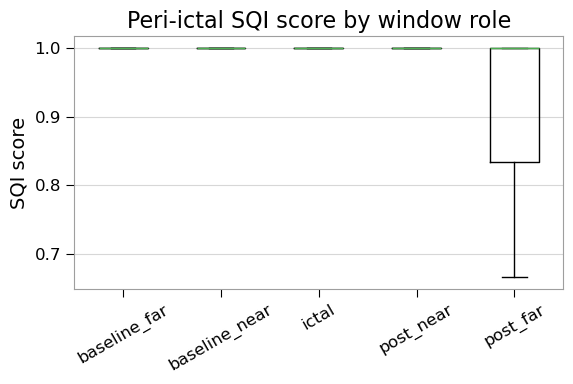

In [31]:
plt.figure(figsize=(6, 4))
roles_order = ["baseline_far", "baseline_near", "ictal", "post_near", "post_far"]

data = [df_sqi_full.loc[df_sqi_full["role"] == r, "sqi_score"] for r in roles_order]
plt.boxplot(data, labels=roles_order, showfliers=False)

plt.ylabel("SQI score")
plt.title("Peri-ictal SQI score by window role")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


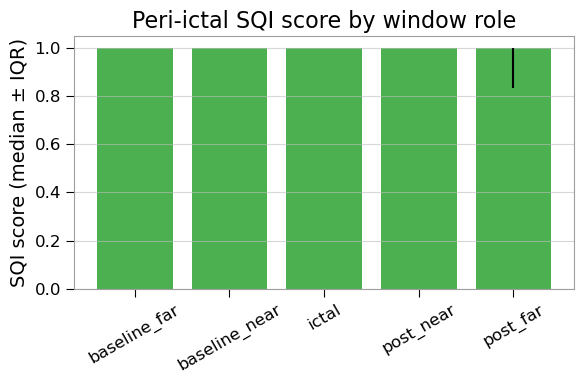

In [32]:
sqi_role_plot = sqi_role.reindex(roles_order)

plt.figure(figsize=(6, 4))
plt.bar(sqi_role_plot.index, sqi_role_plot["median_sqi"], yerr=[
    sqi_role_plot["median_sqi"] - sqi_role_plot["q1_sqi"],
    sqi_role_plot["q3_sqi"] - sqi_role_plot["median_sqi"],
])
plt.ylabel("SQI score (median ± IQR)")
plt.xticks(rotation=30)
plt.title("Peri-ictal SQI score by window role")
plt.tight_layout()
plt.show()


In [33]:
sqi_patient_role = (
    df_sqi_full
    .groupby(["patient_id", "role"])
    .agg(
        n_windows=("is_good", "size"),
        frac_good=("is_good", "mean"),
        median_sqi=("sqi_score", "median"),
    )
    .reset_index()
)

sqi_patient_role.head()


,patient_id,role,n_windows,frac_good,median_sqi
0,1,baseline_far,3,1.000000,1.0
1,1,baseline_near,3,0.666667,1.0
2,1,ictal,3,1.000000,1.0
3,1,post_far,3,1.000000,1.0
4,1,post_near,3,1.000000,1.0


In [34]:
sqi_ictal = sqi_patient_role[sqi_patient_role["role"] == "ictal"]
sqi_ictal.describe()


,patient_id,n_windows,frac_good,median_sqi
count,3.0,3.000000,3.0,3.0
mean,2.0,5.000000,1.0,1.0
std,1.0,3.464102,0.0,0.0
min,1.0,3.000000,1.0,1.0
25%,1.5,3.000000,1.0,1.0
50%,2.0,3.000000,1.0,1.0
75%,2.5,6.000000,1.0,1.0
max,3.0,9.000000,1.0,1.0


Merge to df_all

In [35]:
# Start med metadata (1 række per vindue)
df_meta = df_peri[["recording_uid", "patient_id", "seizure_id", "role"]].reset_index(drop=True)

# Noise
df_noise_clean = df_noise.drop(columns=["recording_uid", "patient_id", "seizure_id", "role"])
df_noise_clean = df_noise_clean.reset_index(drop=True)

# PSD
df_psd_clean = df_psd.drop(columns=["recording_uid", "patient_id", "seizure_id", "role"])
df_psd_clean = df_psd_clean.reset_index(drop=True)

# SQI
df_sqi_clean = df_sqi_full.drop(columns=["recording_uid", "patient_id", "seizure_id", "role"])
df_sqi_clean = df_sqi_clean.reset_index(drop=True)

# Merge alt i ét stort datasæt
df_all = pd.concat(
    [
        df_meta,
        df_noise_clean,
        df_psd_clean,
        df_sqi_clean,
    ],
    axis=1
)

df_all.head()


,recording_uid,patient_id,seizure_id,role,rms,line_noise_ratio,hf_noise_ratio,snr_qrs,ulf_rel,qrs_rel,hf_rel,line_rel,ULF_power,LF_power,QRS-ish_power,HF(40-100)_power,Line(48-52)_power,ULF_rel,LF_rel,QRS-ish_rel,HF(40-100)_rel,Line(48-52)_rel,is_good,sqi_score,flag_amp_ok,flag_ramp_ok,flag_mean_freq_ok,flag_hf_rel_ok,flag_lf_rel_ok,flag_flat_ok,feat_ampdiff,feat_rampdiff,feat_mean_freq,feat_lf_power,feat_hf_power,feat_mains_power,feat_total_power,feat_lf_rel_power,feat_hf_rel_power,feat_mains_rel_power,feat_flat_rampdiff_min,feat_flat_rampdiff_p10
0,P01_R01,1,1,baseline_far,251.116655,0.002971,0.015490,0.690854,0.345709,0.408583,0.006329,0.001214,1.472116e+04,10182.384759,17398.482038,269.500945,51.686736,0.345709,0.239121,0.408583,0.006329,0.001214,True,1.0,True,True,True,True,True,True,2692.336797,2331.337697,7.151316,8863.774226,270.282090,26.334403,3.759638e+04,0.235761,0.007189,0.000700,1171.180285,1184.958877
1,P01_R01,1,1,baseline_near,195.479175,0.002802,0.015186,1.735587,0.065901,0.634448,0.009635,0.001778,2.130206e+03,9359.869345,20508.178370,311.435957,57.472108,0.065901,0.289560,0.634448,0.009635,0.001778,True,1.0,True,True,True,True,True,True,3287.571954,2899.015671,9.496213,2323.586298,334.188310,29.763969,3.452417e+04,0.067303,0.009680,0.000862,1226.294652,1291.880748
2,P01_R01,1,1,ictal,1759.017586,0.004375,0.026703,0.048828,0.845632,0.046555,0.001243,0.000204,2.168194e+06,273060.617322,119366.991859,3187.443687,522.210855,0.845632,0.106498,0.046555,0.001243,0.000204,True,1.0,True,True,True,True,True,True,15556.029908,8848.611521,1.731043,968141.920828,3300.957575,275.942025,1.503440e+06,0.643951,0.002196,0.000184,2190.796063,2232.131838
3,P01_R01,1,1,post_near,600.681599,0.008856,0.062229,0.147161,0.760636,0.128283,0.007983,0.001136,2.259135e+05,30409.571399,38100.694810,2370.974121,337.436330,0.760636,0.102387,0.128283,0.007983,0.001136,True,1.0,True,True,True,True,True,True,4957.537255,3425.357870,4.717348,80770.933223,2123.107393,128.611797,1.593764e+05,0.506794,0.013321,0.000807,1193.226032,1272.039576
4,P01_R01,1,1,post_far,324.644501,0.002032,0.013038,2.295593,0.013677,0.696564,0.009082,0.001415,1.423669e+03,29200.913352,72509.049598,945.342484,147.342083,0.013677,0.280521,0.696564,0.009082,0.001415,True,1.0,True,True,True,True,True,True,3309.617700,2893.504234,11.035400,1187.589834,962.535956,75.498483,1.040264e+05,0.011416,0.009253,0.000726,2323.070542,2372.673472


## 3A Peri-ictal Noise Analysis

In [36]:
noise_cols = [
    "rms", "snr_qrs", "hf_noise_ratio", "line_noise_ratio",
    "ulf_rel", "qrs_rel", "hf_rel", "line_rel",
]

df_noise_role = (
    df_all.groupby("role")[noise_cols]
    .agg(["median", "mean", "std"])
)

df_noise_role


rms                             snr_qrs            \
                    median         mean          std    median      mean   
role                                                                       
baseline_far    273.309221   342.037240   172.254663  0.552275  0.703916   
baseline_near   286.958090   456.197523   392.103449  0.414179  0.507396   
ictal          2285.821684  2079.422972  1020.230746  0.027766  0.099377   
post_far        264.700720   456.772082   648.666368  0.525619  0.868330   
post_near       298.125238   450.843331   266.977855  0.480047  0.463355   

                        hf_noise_ratio                     line_noise_ratio  \
                    std         median      mean       std           median   
role                                                                          
baseline_far   0.547147       0.021455  0.021771  0.014943         0.001465   
baseline_near  0.436929       0.024962  0.022691  0.015845         0.001397   
ictal          0.245870       0.053439  0.065287  0.038560         0.004982   
post_far       0.804563       0.026092  0.029133  0.024947         0.001566   
post_near      0.332278       0.025548  0.028878  0.017329         0.002095   

                                    ulf_rel                       qrs_rel  \
                   mean       std    median      mean       std    median   
role                                                                        
baseline_far   0.001437  0.000930  0.159796  0.258432  0.242429  0.355784   
baseline_near  0.001712  0.001435  0.277471  0.329861  0.272593  0.292876   
ictal          0.005953  0.003683  0.780039  0.728911  0.202978  0.027016   
post_far       0.002168  0.001974  0.130597  0.212449  0.266722  0.344529   
post_near      0.002368  0.001943  0.403244  0.362827  0.321119  0.324346   

                                     hf_rel                      line_rel  \
                   mean       std    median      mean       std    median   
role                                                                        
baseline_far   0.364861  0.169403  0.006787  0.006745  0.004089  0.000489   
baseline_near  0.295206  0.160791  0.004502  0.005892  0.004872  0.000299   
ictal          0.064868  0.123125  0.001312  0.002113  0.001770  0.000135   
post_far       0.382411  0.216531  0.006961  0.007829  0.005912  0.000399   
post_near      0.283590  0.158477  0.004227  0.007365  0.005468  0.000553   

                                   
                   mean       std  
role                               
baseline_far   0.000484  0.000342  
baseline_near  0.000447  0.000500  
ictal          0.000210  0.000208  
post_far       0.000650  0.000551  
post_near      0.000528  0.000303

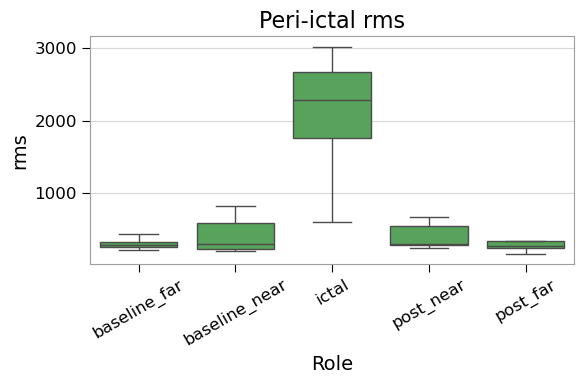

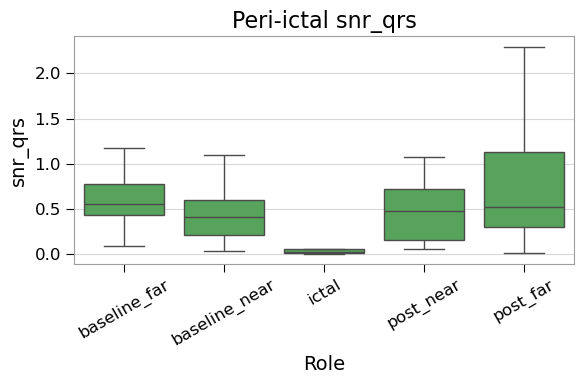

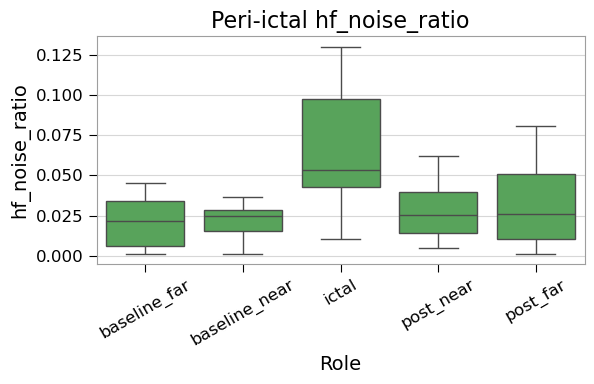

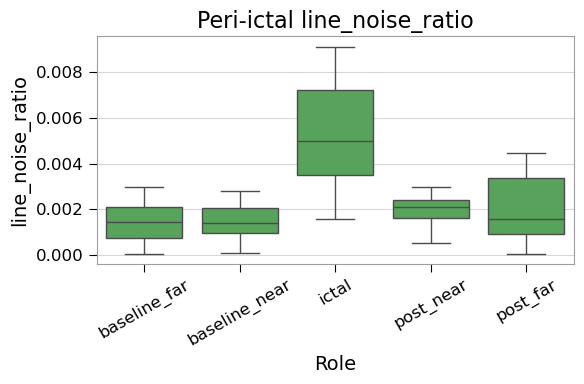

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Peri-ictal line_noise_ratio'}, xlabel='Role', ylabel='line_noise_ratio'>)

In [39]:
from src.hrv_epatch.plots.peri_noise import plot_peri_noise_feature

plot_peri_noise_feature(df_all, "rms")
plot_peri_noise_feature(df_all, "snr_qrs")
plot_peri_noise_feature(df_all, "hf_noise_ratio")
plot_peri_noise_feature(df_all, "line_noise_ratio")



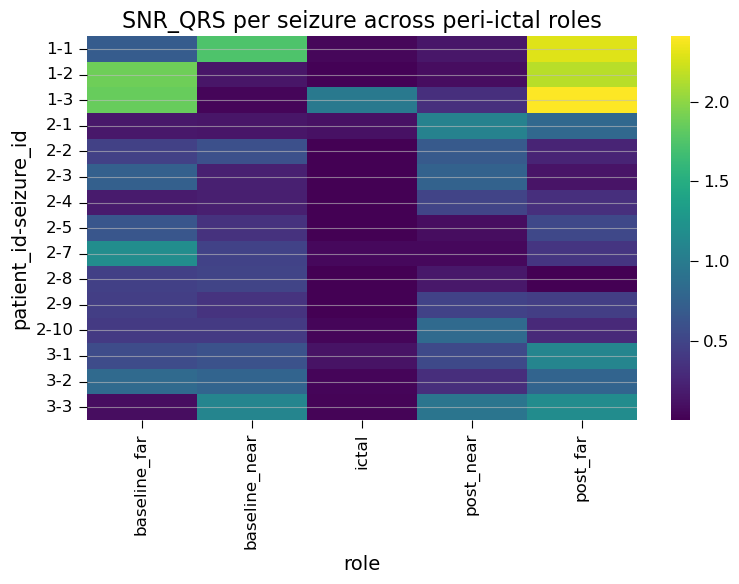

In [38]:
pivot_noise = df_all.pivot_table(
    index=["patient_id", "seizure_id"],
    columns="role",
    values="snr_qrs"
).reindex(columns=["baseline_far", "baseline_near", "ictal", "post_near", "post_far"])

plt.figure(figsize=(8,6))
sns.heatmap(pivot_noise, cmap="viridis")
plt.title("SNR_QRS per seizure across peri-ictal roles")
plt.tight_layout()
plt.show()


## 3B PSD-analysis

In [40]:
[col for col in df_all.columns if "_power" in col or "_rel" in col]


['ulf_rel',
 'qrs_rel',
 'hf_rel',
 'line_rel',
 'ULF_power',
 'LF_power',
 'QRS-ish_power',
 'HF(40-100)_power',
 'Line(48-52)_power',
 'ULF_rel',
 'LF_rel',
 'QRS-ish_rel',
 'HF(40-100)_rel',
 'Line(48-52)_rel',
 'flag_hf_rel_ok',
 'flag_lf_rel_ok',
 'feat_lf_power',
 'feat_hf_power',
 'feat_mains_power',
 'feat_total_power',
 'feat_lf_rel_power',
 'feat_hf_rel_power',
 'feat_mains_rel_power']

In [41]:
psd_rel_cols = [c for c in df_all.columns if c.endswith("_rel")]

df_psd_role = (
    df_all
    .groupby("role")[psd_rel_cols]
    .agg(["median", "mean", "std"])
)

df_psd_role


ulf_rel                       qrs_rel                      \
                 median      mean       std    median      mean       std   
role                                                                        
baseline_far   0.159796  0.258432  0.242429  0.355784  0.364861  0.169403   
baseline_near  0.277471  0.329861  0.272593  0.292876  0.295206  0.160791   
ictal          0.780039  0.728911  0.202978  0.027016  0.064868  0.123125   
post_far       0.130597  0.212449  0.266722  0.344529  0.382411  0.216531   
post_near      0.403244  0.362827  0.321119  0.324346  0.283590  0.158477   

                 hf_rel                      line_rel                      \
                 median      mean       std    median      mean       std   
role                                                                        
baseline_far   0.006787  0.006745  0.004089  0.000489  0.000484  0.000342   
baseline_near  0.004502  0.005892  0.004872  0.000299  0.000447  0.000500   
ictal          0.001312  0.002113  0.001770  0.000135  0.000210  0.000208   
post_far       0.006961  0.007829  0.005912  0.000399  0.000650  0.000551   
post_near      0.004227  0.007365  0.005468  0.000553  0.000528  0.000303   

                ULF_rel                        LF_rel                      \
                 median      mean       std    median      mean       std   
role                                                                        
baseline_far   0.159796  0.258432  0.242429  0.364888  0.368945  0.151674   
baseline_near  0.277471  0.329861  0.272593  0.350220  0.368147  0.176662   
ictal          0.780039  0.728911  0.202978  0.155824  0.203722  0.112624   
post_far       0.130597  0.212449  0.266722  0.394875  0.396397  0.168714   
post_near      0.403244  0.362827  0.321119  0.293900  0.345096  0.192184   

              QRS-ish_rel                     HF(40-100)_rel            \
                   median      mean       std         median      mean   
role                                                                     
baseline_far     0.355784  0.364861  0.169403       0.006787  0.006745   
baseline_near    0.292876  0.295206  0.160791       0.004502  0.005892   
ictal            0.027016  0.064868  0.123125       0.001312  0.002113   
post_far         0.344529  0.382411  0.216531       0.006961  0.007829   
post_near        0.324346  0.283590  0.158477       0.004227  0.007365   

                        Line(48-52)_rel                      
                    std          median      mean       std  
role                                                         
baseline_far   0.004089        0.000489  0.000484  0.000342  
baseline_near  0.004872        0.000299  0.000447  0.000500  
ictal          0.001770        0.000135  0.000210  0.000208  
post_far       0.005912        0.000399  0.000650  0.000551  
post_near      0.005468        0.000553  0.000528  0.000303

In [42]:
df_psd_role_long = df_psd_role.stack(level=0).reset_index()
df_psd_role_long.head()


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_3668\3268273584.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_psd_role_long = df_psd_role.stack(level=0).reset_index()


,role,level_1,median,mean,std
0,baseline_far,HF(40-100)_rel,0.006787,0.006745,0.004089
1,baseline_far,LF_rel,0.364888,0.368945,0.151674
2,baseline_far,Line(48-52)_rel,0.000489,0.000484,0.000342
3,baseline_far,QRS-ish_rel,0.355784,0.364861,0.169403
4,baseline_far,ULF_rel,0.159796,0.258432,0.242429


3B.3 BoxPlots af PSD-rel-power pr rolle

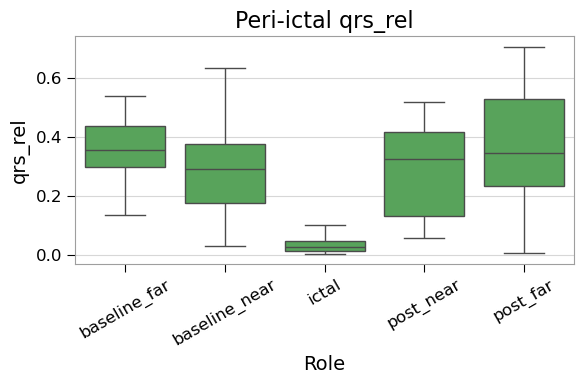

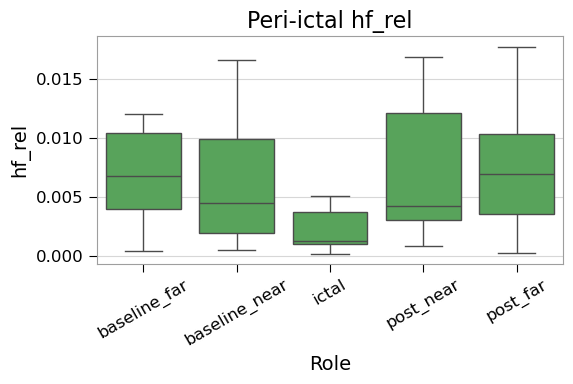

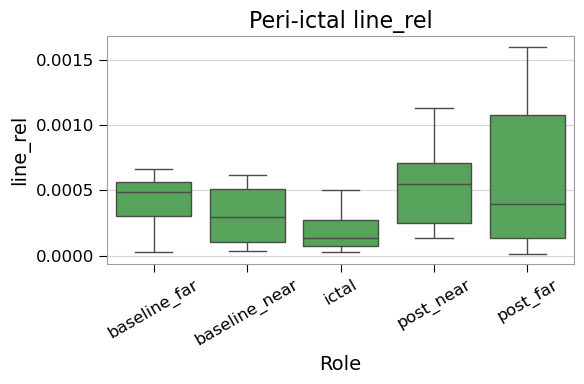

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Peri-ictal line_rel'}, xlabel='Role', ylabel='line_rel'>)

In [46]:
from src.hrv_epatch.plots.peri_psd import plot_peri_psd_feature

plot_peri_psd_feature(df_all, "qrs_rel")
plot_peri_psd_feature(df_all, "hf_rel")
plot_peri_psd_feature(df_all, "line_rel")

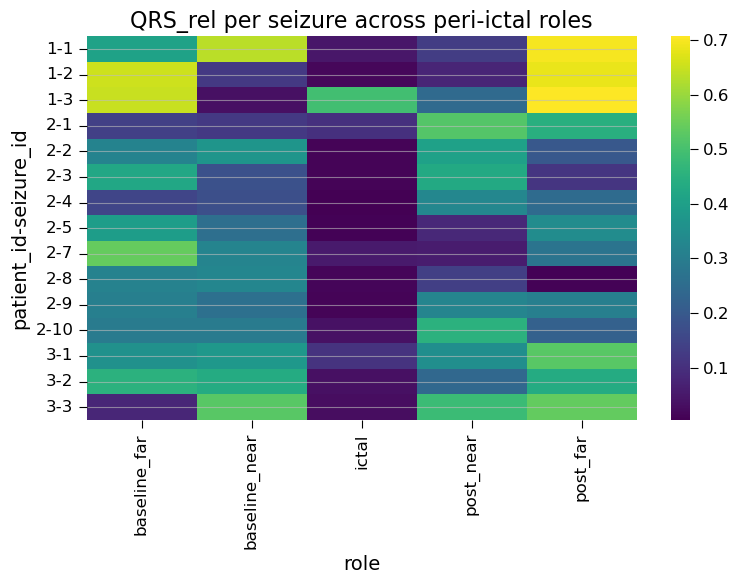

In [47]:
import seaborn as sns
pivot_qrs = df_all.pivot_table(
    index=["patient_id", "seizure_id"],
    columns="role",
    values="qrs_rel",
).reindex(columns=["baseline_far", "baseline_near", "ictal", "post_near", "post_far"])

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_qrs, cmap="viridis")
plt.title("QRS_rel per seizure across peri-ictal roles")
plt.tight_layout()
plt.show()


## 3C.1 

In [48]:
roles_order = ["baseline_far", "baseline_near", "ictal", "post_near", "post_far"]

df_sqi_role = (
    df_sqi_full
    .groupby("role")
    .agg(
        n_windows=("is_good", "size"),
        n_good=("is_good", "sum"),
        median_sqi=("sqi_score", "median"),
        q1=("sqi_score", lambda x: x.quantile(0.25)),
        q3=("sqi_score", lambda x: x.quantile(0.75)),
    )
    .reindex(roles_order)
)

df_sqi_role["frac_good"] = df_sqi_role["n_good"] / df_sqi_role["n_windows"]
df_sqi_role["percent_good"] = 100 * df_sqi_role["frac_good"]

df_sqi_role


,n_windows,n_good,median_sqi,q1,q3,frac_good,percent_good
role,,,,,,,
baseline_far,15,14,1.0,1.000000,1.0,0.933333,93.333333
baseline_near,15,13,1.0,1.000000,1.0,0.866667,86.666667
ictal,15,15,1.0,1.000000,1.0,1.000000,100.000000
post_near,15,13,1.0,1.000000,1.0,0.866667,86.666667
post_far,15,10,1.0,0.833333,1.0,0.666667,66.666667


## 8. Noise and spectral characteristics

We complement the SQI analysis with PSD-based noise metrics and bandpower
profiles for selected segments / patients.

In [ ]:
example_seg = segment_index.iloc[0]
rec = df_rec[df_rec["recording_uid"] == example_seg["recording_uid"]].iloc[0]

sig, meta = load_tdms_from_path(rec["tdms_path"], channel_hint="EKG")
x_seg = extract_segment_signal(sig, meta, example_seg)

nm = noise_metrics(x_seg, fs=meta.fs)
print(nm)

f, Pxx = compute_psd(x_seg, fs=meta.fs)
bands = summarize_psd_bands(f, Pxx)
display(bands)

plot_psd(x_seg, fs=meta.fs, fmax=100.0)
plt.tight_layout()
plt.show()


## 9. Peri-ictal windows around seizures

In addition to the global 60 s segmentation, we construct peri-ictal windows
around each seizure to study how signal characteristics change before, during,
and after clinical events.

We reuse the previous scheme:
- seizure-only windows (matching seizure duration)
- seizure ±2 minutes
- “clean” baseline windows ~20 minutes before seizure

In [ ]:
# Eksempel: analyser peri-ictal vinduer for et subset af seizures
# analyze_shifted_windows kan tage en liste af offsets (i sek/min) og vindueslængde.
# Du tilpasser signaturen til din faktiske implementation.

peri_rows = []

for ridx, rec in df_rec.head(3).iterrows():
    sig, meta = load_tdms_from_path(rec["tdms_path"], channel_hint="EKG")
    events_here = df_evt[df_evt["recording_uid"] == rec["recording_uid"]]

    for _, ev in events_here.iterrows():
        # TODO: konverter absolute_start til sekunder fra rec-start hvis nødvendigt
        # t_seizure = ...
        # res = analyze_shifted_windows(
        #     signal=sig,
        #     fs=meta.fs,
        #     seizure_t0=t_seizure,
        #     offsets_min=PERIICTAL_OFFSETS_MIN,
        #     window_len_s=PERIICTAL_WINDOW_LEN_S,
        # )
        # for row in res:
        #     peri_rows.append({**row, "recording_uid": rec["recording_uid"], "seizure_id": ev["seizure_id"]})
        pass

# df_peri = pd.DataFrame(peri_rows)
# display(df_peri.head())


## 10. Case-study plots

Finally, we generate a small number of illustrative plots for selected seizures:
- raw vs cleaned ECG with R-peaks from different detectors
- peri-ictal scalograms / PSD
- segment-level SQI and noise metrics across time

In [ ]:
# Placeholder: vælg en patient + et tidsinterval
rec = df_rec.iloc[0]
sig, meta = load_tdms_from_path(rec["tdms_path"], channel_hint="EKG")

t0_sec = 0.0
t1_sec = 60.0

# TODO: generér eller load dine peaks (peaks_main, peaks_ref)
# peaks_main = ...
# peaks_ref = ...

# plot_raw_vs_clean_with_peaks(sig, sig_clean, peaks_main, peaks_ref, fs=meta.fs, t0=t0_sec, t1=t1_sec)


## 11. Export of tables and figures

We finally export the key tables and figures used in the thesis, so that the
LaTeX document can include them directly.

In [ ]:
df_rec.to_csv(OUT_DIR / "recordings_overview.csv", index=False)
df_evt.to_csv(OUT_DIR / "seizure_events.csv", index=False)
segment_index.to_csv(OUT_DIR / "segment_index_60s.csv", index=False)

# Hvis du har df_sqi og df_peri:
# df_sqi.to_csv(OUT_DIR / "segment_sqi.csv", index=False)
# df_peri.to_csv(OUT_DIR / "peri_ictal_windows.csv", index=False)